# Estimating Urban Service Levels

First we load city boundaries, and partition the city in a grid

In [30]:
import sys
sys.path.append('..')
import urbanpy as up
import osmnx as ox
import geopandas as gpd
import numpy as np

In [2]:
lima_boundaries = up.download.nominatim_osm('lima, peru')

In [3]:
lima_hexs = up.geom.gen_hexagons(9, lima_boundaries)

In [4]:
lima_hexs.shape

(172, 2)

## How are we going to estimate urban service level?

For each hexagon (centroid) we are going to generate isochrones for 30 minutes walk, with 5 minutes bands. For each band we are going to count the number of PoIs by categories.

### Isochrones Demo

#### Load Graphs

In [5]:
lima_metro_boundaries = up.geom.merge_geom_downloads(
    [up.download.nominatim_osm('Lima, Peru', 2),
    up.download.nominatim_osm('Callao, Peru', 1)]
)

In [6]:
(lima_metro_boundaries.explode().area / lima_metro_boundaries.area[0]).round(4).idxmax()

# The polygon with greatest area is >99% of the total multipolygon area

(0, 10)

In [7]:
lima_graph = up.download.osmnx_graph('polygon', 'walk', geom=lima_metro_boundaries.explode().geometry[0][10])

In [8]:
lima_downtown_graph = up.download.osmnx_graph('place', 'walk', 'Lima, Peru')

In [10]:
lima_graph_proj = ox.project_graph(lima_graph)

In [11]:
lima_downtown_graph_proj = ox.project_graph(lima_downtown_graph)

In [12]:
[lima_downtown_graph_proj.nodes[4578479048]['y'],
lima_downtown_graph_proj.nodes[4578479048]['x']]

[-1333048.5299343618, 274631.8161092551]

In [13]:
[lima_downtown_graph_proj.nodes[4578479061]['y'],
lima_downtown_graph_proj.nodes[4578479061]['x']]

[-1333026.0715693592, 274795.5781210733]

#### Generate isochrones (with graph size - time benchmarking)

In [14]:
isochrones = up.routing.isochrone_from_graph(
    graph=lima_graph, 
    locations=[[lima_graph.nodes[4578479048]['x'], 
                lima_graph.nodes[4578479048]['y']]],
    time_range=[5, 10],
    profile='walking'
)

#### Visualize isochrone

&lt;AxesSubplot:&gt;

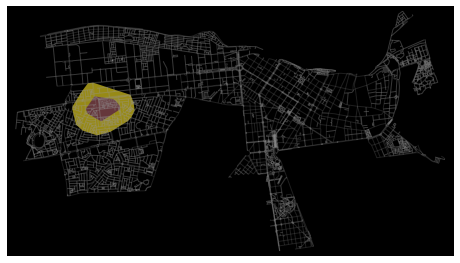

In [16]:
fig, ax = ox.plot_graph(lima_downtown_graph_proj, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k')

isochrones.plot('contour', ax=ax, alpha=0.6, zorder=-1)

In [15]:
TIME_BENCHMARK = False

In [17]:
%%timeit
if TIME_BENCHMARK:
    up.routing.isochrone_from_graph(lima_graph, [[lima_graph.nodes[4578479048]['x'], lima_graph.nodes[4578479048]['y']]], [5, 10], 'walking')

16.7 ns ± 0.33 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [18]:
%%timeit
if TIME_BENCHMARK:
    up.routing.isochrone_from_graph(lima_downtown_graph, [[lima_graph.nodes[4578479048]['x'], lima_graph.nodes[4578479048]['y']]], [5, 10], 'walking')

16 ns ± 0.156 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


### Scale isochrone calculation up to every hexagon centroid in Lima's Downtown

In [19]:
lima_hexs['lon'] = lima_hexs.geometry.centroid.x
lima_hexs['lat'] = lima_hexs.geometry.centroid.y

hexs_centroids = lima_hexs[['lon','lat']].values.tolist()

In [20]:
downtown_isochrones = up.routing.isochrone_from_graph(
    graph=lima_graph, 
    locations=hexs_centroids,
    time_range=[5, 10, 15, 20, 25, 30], 
    profile='walking'
)

In [21]:
downtown_isochrones.head()

group_index  contour                                           geometry
0            0       30  POLYGON ((274897.754 -1335960.741, 273977.795 ...
1            0       25  POLYGON ((274842.483 -1335607.075, 274643.488 ...
2            0       20  POLYGON ((274481.253 -1335266.532, 273812.099 ...
3            0       15  POLYGON ((274266.258 -1334915.579, 273802.071 ...
4            0       10  POLYGON ((274593.086 -1334632.916, 274454.864 ...

In [22]:
downtown_isochrones.shape

(1032, 3)

In [24]:
# Validate every geom is of the correct type
(downtown_isochrones.geom_type != 'Polygon').sum()

0

In [35]:
# Save output
downtown_isochrones.to_file('output/lima_downtown_isochrones.geojson', driver='GeoJSON')

#### Visualize an isochromes sample in a map

In [31]:
SAMPLE_SIZE = 5

In [33]:
# Create sample & filter time ranges for a better visualization
n_isochrones = downtown_isochrones.shape[0]
random_indices = np.random.choice(downtown_isochrones['group_index'].unique(), size=SAMPLE_SIZE, replace=False)

sample_filter = downtown_isochrones['group_index'].isin(random_indices)
timer_filter = downtown_isochrones['contour'].isin([5, 10, 15])

ischrones_rsample = downtown_isochrones[sample_filter & timer_filter]

&lt;AxesSubplot:&gt;

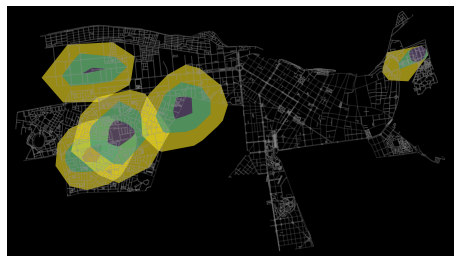

In [34]:
fig, ax = ox.plot_graph(lima_downtown_graph_proj, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k')

ischrones_rsample.plot('contour', ax=ax, alpha=0.6, zorder=-1)

### Which PoIs categories we are going to use for estimating service levels?

- Food & Beverage (Restaurants & similar )
- Cultural places
- Night Places
- Pharmacies & Sanitization
- Sports Equiptment 
- Clothes & Shoes
- Furniture
- Beauty
- Nanostores
- Traditional Markets